In [26]:
import xarray as xr
import numpy as np

# Load datasets (paths from your PDF)
ds_stat = xr.load_dataset("/Users/PARKJIHYEON/phys763/qolab-start/data/2025-12-01/#127_GSS4_105336/ds_stat.h5")
ds_seq  = xr.load_dataset("/Users/PARKJIHYEON/phys763/qolab-start/data/2025-12-01/#127_GSS4_105336/ds_seq.h5")

ds_stat = xr.load_dataset("/Users/PARKJIHYEON/phys763/qolab-start/data/2025-12-01/#134_GSS4_200516/ds_stat.h5")
ds_seq  = xr.load_dataset("/Users/PARKJIHYEON/phys763/qolab-start/data/2025-12-01/#134_GSS4_200516/ds_seq.h5")

ds_stat = xr.load_dataset("/Users/PARKJIHYEON/phys763/qolab-start/data/2025-12-01/#135_GSS4_202749/ds_stat.h5")
ds_seq  = xr.load_dataset("/Users/PARKJIHYEON/phys763/qolab-start/data/2025-12-01/#135_GSS4_202749/ds_seq.h5")

print(ds_stat)
print(ds_seq)


<xarray.Dataset> Size: 28kB
Dimensions:      (qubit: 1, sequence: 1000, depths: 6)
Coordinates:
  * qubit        (qubit) object 8B 'q4'
  * sequence     (sequence) int32 4kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * depths       (depths) float64 48B 1.0 2.0 4.0 6.0 8.0 10.0
Data variables:
    state_raw_q  (qubit, sequence, depths) int32 24kB 1 0 1 0 0 0 ... 0 0 1 1 1
<xarray.Dataset> Size: 44kB
Dimensions:     (qubit: 1, sequence: 1000, positions: 10)
Coordinates:
  * qubit       (qubit) object 8B 'q4'
  * sequence    (sequence) int32 4kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * positions   (positions) int32 40B 0 1 2 3 4 5 6 7 8 9
Data variables:
    sequence_q  (qubit, sequence, positions) int32 40kB 16 10 13 17 ... 11 16 14


In [27]:
# 1. Pick qubit
qubit_name = "q4"

# 2. Measurement outcomes: shape (num_sequences, num_depths)
state = ds_stat["state_raw_q"].sel(qubit=qubit_name).values   # (K: sequence, M: depths)

# 3. Gate labels: shape (num_sequences, max_positions)
seq_labels = ds_seq["sequence_q"].sel(qubit=qubit_name).values  # (K, M_max)

# 4. Depths (prefix lengths actually used)
depths = ds_stat["depths"].values  # shape (M,), e.g. [1., 50., 100., ..., 1000.]



In [28]:
import numpy as np

# --- Pauli matrices ---
I2 = np.array([[1, 0],
               [0, 1]], dtype=complex)
X  = np.array([[0, 1],
               [1, 0]], dtype=complex)
Y  = np.array([[0, -1j],
               [1j, 0]], dtype=complex)
Z  = np.array([[1, 0],
               [0, -1]], dtype=complex)

# --- normalized Pauli basis σ_i/√2, just like in GSS_tools.py ---
norm_fac = 1.0 / np.sqrt(2.0)
norm_pauli_basis = [
    norm_fac * I2,  # index 0
    norm_fac * X,   # index 1
    norm_fac * Y,   # index 2
    norm_fac * Z,   # index 3
]

def PTM_norm(U: np.ndarray) -> np.ndarray:
    
    Cd = U.conj().T
    R = np.zeros((4, 4), dtype=complex)
    for i, sigma_i in enumerate(norm_pauli_basis):
        for j, sigma_j in enumerate(norm_pauli_basis):
            R[i, j] = np.trace(sigma_i.conj().T @ (U @ (sigma_j @ Cd)))
    return R


In [29]:
# --- SU(2) rotations from Pauli generators ---
def U_rot(P: np.ndarray, theta: float) -> np.ndarray:
    """
    Single-qubit rotation: exp(-i * theta/2 * P), with P^2 = I.
    """
    return np.cos(theta/2) * I2 - 1j * np.sin(theta/2) * P

# elementary x/y rotations
Ux90  = U_rot(X,  np.pi/2)
U_x90 = U_rot(X, -np.pi/2)
Ux180 = U_rot(X,  np.pi)

Uy90  = U_rot(Y,  np.pi/2)
U_y90 = U_rot(Y, -np.pi/2)
Uy180 = U_rot(Y,  np.pi)

# --- Clifford table: label -> unitary ---
U_clifford = {}

U_clifford[0]  = I2
U_clifford[1]  = Ux180
U_clifford[2]  = Uy180
U_clifford[3]  = Ux180 @ Uy180

U_clifford[4]  = Uy90  @ Ux90
U_clifford[5]  = U_y90 @ Ux90
U_clifford[6]  = Uy90  @ U_x90
U_clifford[7]  = U_y90 @ U_x90

U_clifford[8]  = Ux90  @ Uy90
U_clifford[9]  = U_x90 @ Uy90
U_clifford[10] = Ux90  @ U_y90
U_clifford[11] = U_x90 @ U_y90

U_clifford[12] = Ux90
U_clifford[13] = U_x90
U_clifford[14] = Uy90
U_clifford[15] = U_y90

U_clifford[16] = Ux90  @ Uy90  @ U_x90
U_clifford[17] = Ux90  @ U_y90 @ U_x90
U_clifford[18] = Uy90  @ Ux180
U_clifford[19] = U_y90 @ Ux180
U_clifford[20] = Ux90  @ Uy180
U_clifford[21] = U_x90 @ Uy180
U_clifford[22] = Ux90  @ Uy90  @ Ux90
U_clifford[23] = U_x90 @ Uy90  @ U_x90


In [30]:
# --- projector A onto non-identity component (same as k_estimator_mean) ---
A_GSS = np.eye(4, dtype=complex)
A_GSS[0, 0] = 0.0   # kill identity, keep X,Y,Z
# --- gate-specific A for x180 ---
# basis indices: 0->I, 1->X, 2->Y, 3->Z
A_x180 = np.zeros((4, 4), dtype=complex)
A_x180[2, 2] = 1.0   # keep Y
A_x180[3, 3] = 1.0   # keep Z

A_GSS = A_x180
# --- "reference state" |0>> in Liouville space: (1/√2)*I ---
#rho_mat = (1.0 / np.sqrt(2.0)) * np.eye(2, dtype=complex)
#rho_vec = rho_mat.flatten()   # length-4 vector in normalized Pauli basis
#rho_vec = np.array([1.0, 0.0, 0.0, 0.0], dtype=complex)
rho_vec = (1.0 / 2.0) * np.array([1.0, 0.0, 0.0, 1.0], dtype=complex)


def f_from_labels(labels_prefix, outcome):
    op = np.eye(4, dtype=complex) #?? initial
    for lbl in labels_prefix:
        U = U_clifford[int(lbl)]
        C = PTM_norm(U)
        op = A_GSS @ C @ op

    if outcome == 0:
        E_vec = (1.0 / 2.0) * np.array([1.0, 0.0, 0.0,  1.0])
    else:
        E_vec = (1.0 / 2.0) * np.array([1.0, 0.0, 0.0, -1.0])

    return (E_vec.conj().T @ (op @ rho_vec)).real


def f_from_labels(labels_prefix, outcome, rho_vec):
    op = rho_vec
    for lbl in labels_prefix:
        U = U_clifford[int(lbl)]
        C = PTM_norm(U)
        if lbl < len(labels_prefix) - 1:
            op = A_GSS @ C @ op

    if outcome == 0:
        E_vec = (1.0 / 2.0) * np.array([1.0, 0.0, 0.0,  1.0])
    else:
        E_vec = (1.0 / 2.0) * np.array([1.0, 0.0, 0.0, -1.0])

    return 3*(E_vec.conj().T @ op ).real #3 is alpha

In [31]:
import matplotlib.pyplot as plt

# state:    shape (K, M) – outcomes 0/1
# seq_labels: shape (K, max_depth) – Cliff labels
# depths:  shape (M,) – number of gates at each depth index j

K, M = state.shape
khat = np.zeros(M)
sigma = np.zeros(M)

for j in range(M):          # loop over depth indices
    m = int(depths[j])
    vals = []
    print(f"m:{m}")
    for k in range(K):      # loop over sequences
        labels_prefix = seq_labels[k, :m]
        outcome = int(state[k, j])
        #print(outcome)
        vals.append(f_from_labels(labels_prefix, outcome, rho_vec))
        #print(f"val:{f_from_labels(labels_prefix, outcome)}")
    khat[j] = np.mean(vals)   # mean estimator (like k_estimator_mean)
    sigma[j] = np.std(vals)

#print(khat[j0])

m:1
m:2
m:4
m:6
m:8
m:10


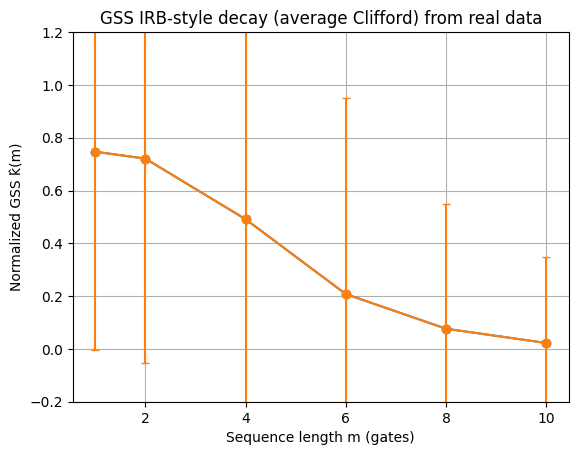

In [34]:
# --- normalized decay G(m) = k(m) / k(m0) ---
j0 = 0   # assuming depths[0] is your smallest nonzero depth
#G_m = khat / khat[j0]
G_m = khat
#G_err = sigma / abs(khat[j0])
G_err = sigma

plt.figure()
plt.plot(depths, G_m, "o-")
plt.errorbar(depths, G_m, yerr=G_err, fmt="o-", capsize=3)
plt.xlabel("Sequence length m (gates)")
plt.ylabel("Normalized GSS k̂(m)")
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.title("GSS IRB-style decay (average Clifford) from real data")
plt.show()


In [33]:
# crude exponential fit: G(m) ≈ C * λ^(m-1)
mask = (G_m > 0) & np.isfinite(G_m)
m_fit = depths[mask].astype(float)
y_fit = G_m[mask]

if len(m_fit) >= 2:
    logy = np.log(y_fit)
    A_mat = np.vstack([np.ones_like(m_fit), m_fit]).T
    coeffs, *_ = np.linalg.lstsq(A_mat, logy, rcond=None)
    logC, loglam = coeffs
    lam = np.exp(loglam)
    print(f"Effective λ ≈ {lam:.6f}")
    print(f"RB p from standard RB fit ≈ 0.99915 (for comparison)")
else:
    print("Not enough positive points to fit an exponential.")


Effective λ ≈ 0.675670
RB p from standard RB fit ≈ 0.99644 (for comparison)
